In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('static')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit
from Vortex import *

In [2]:
# random seed
np.random.seed(1145141)

In [3]:
def sample_wave_dispersion(r_grid, k_mean, k_cov, t=0, f_omega=lambda x: 0, n_wave=100, kappa=1e8, seed=None):
    """
    Sample random wave

    This function generates the randomwave structure at given time step providing given wave dispersion function.

    Parameters:
    - r_grid (list of numpy arrays): The grid of positions where the wave is calculated.
    - k_mean (numpy array): The mean wave vector.
    - k_cov (numpy array): The covariance matrix of the wave vector.
    - t (float, optional): Time. Default is 0.
    - f_omega (function, optional): The function that calculates the angular frequency. Default is a constant function returning 0 (not traveling).
    - n_wave (int, optional): The number of waves to sample. Default is 100.
    - kappa (float, optional): The kappa parameter for the von Mises-Fisher orientation distribution. Default is 1e8.
    - seed (int, optional): The random seed for reproducibility. Default is None.

    Returns:
    - rho (numpy array): Randomwave.

    """
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    np.random.seed(seed)
    for i in range(n_wave):
        flip = 2*(i%2)-1
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        omega_t = f_omega(k_sample_rot)*t*flip
        phi_r = np.random.rand()*2*np.pi-np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + omega_t + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    # print(omega_t)
    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def scale_rho(rho, xyz, scale):
    rho = ndimage.zoom(rho, scale, order=1)
    # r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    x_zoom = ndimage.zoom(x, scale, order=1)
    y_zoom = ndimage.zoom(y, scale, order=1)
    z_zoom = ndimage.zoom(z, scale, order=1)
    r_grid = np.meshgrid(x_zoom,y_zoom,z_zoom)
    return rho, r_grid

## Real space structure

In [4]:
## dispersion relationship
def f_omega_deBroglie(k,D=1):
    k_norm = np.linalg.norm(k)
    return D*k_norm**2

def f_omega_em(k,c=1):
    k_norm = np.linalg.norm(k)
    return c*k_norm

## Meshgrid
n_grid = 128
scale = 6
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0.05]
kappa_list = [256]

parameters_list = []
rho_list = []

t_list = np.linspace(0,0.02,81)/scale

for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        rho_t = []
        for t in t_list:
            ## Random wave
            # sigma_k = 0.025
            # kappa = 1
            alpha = 0

            parameters = [sigma_k,kappa,alpha]
            parameters_list.append(parameters)

            print('parameters = [{:0.2f}, {:0>3d}, {:0.2f}]'.format(*parameters))

            #### Wave vector distribution ####
            k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
            # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
            k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
            k_cov  = np.diagflat(k_var)

            rho = sample_wave_dispersion(r_grid, k_mean_z, k_cov, t=t, f_omega=f_omega_deBroglie, n_wave = 50, kappa=kappa, seed=1145141)
            rho_t.append(rho) # append this timestep
            
        rho_list.append(rho_t)

parameters = [0.05, 256, 0.00]
0.0
parameters = [0.05, 256, 0.00]
0.060539274535283995
parameters = [0.05, 256, 0.00]
0.12107854907056799
parameters = [0.05, 256, 0.00]
0.181617823605852
parameters = [0.05, 256, 0.00]
0.24215709814113598
parameters = [0.05, 256, 0.00]
0.30269637267641997
parameters = [0.05, 256, 0.00]
0.363235647211704
parameters = [0.05, 256, 0.00]
0.423774921746988
parameters = [0.05, 256, 0.00]
0.48431419628227196
parameters = [0.05, 256, 0.00]
0.5448534708175561
parameters = [0.05, 256, 0.00]
0.6053927453528399
parameters = [0.05, 256, 0.00]
0.6659320198881239
parameters = [0.05, 256, 0.00]
0.726471294423408
parameters = [0.05, 256, 0.00]
0.787010568958692
parameters = [0.05, 256, 0.00]
0.847549843493976
parameters = [0.05, 256, 0.00]
0.90808911802926
parameters = [0.05, 256, 0.00]
0.9686283925645439
parameters = [0.05, 256, 0.00]
1.029167667099828
parameters = [0.05, 256, 0.00]
1.0897069416351122
parameters = [0.05, 256, 0.00]
1.150246216170396
parameters = [0.05,

In [5]:
def visualize_defect_accumulated(r_grid,rho_t,n_grid_scale,
                       lamellar=False,isometric=False,alpha=0,
                       lw=1,
                       color='#303030',
                       filename = './test_defect.png'):
    
    pl = pv.Plotter(window_size=[600, 600])
    for i_t, t in tqdm(enumerate(t_list)):
        rho = rho_t[i_t]
        scale_zoom = n_grid_scale/rho.shape[0]

        rho, r_grid = scale_rho(rho, [x,y,z], scale_zoom)

        rho_real = rho.real
        rho_imag = rho.imag
        rho_phase = np.angle(rho)

        ## identify vortex_lines
        vortex_volume = vortex_phase(rho_phase)

        array = vortex_volume
        positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
        poslist_arr = np.array(positions_tuple_list)

        parts_arr = get_connected_part(adjacent_id_list)
        max_part = 0
        if len(parts_arr) != 0:
            max_part = np.max(parts_arr)

        sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)

        sample_ordered = get_ordered_points(sample, sample_adj_list)
    
        # pyvista
        # https://stackoverflow.com/questions/6030098
        grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
        grid["vol"] = rho_real.flatten('F')
        mesh = grid.contour([0])

        # Visualization
        pv.set_plot_theme('document')
        pl.enable_anti_aliasing('msaa')

        if lamellar:
            backface_params = dict(color=color,
                                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                                opacity=1
                                )
            pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                        backface_params=backface_params, 
                        smooth_shading=True, 
                        opacity=1
                        )
        mesh_cube = pv.Cube(bounds=[0,n_grid_scale,0,n_grid_scale,0,n_grid_scale])
        pl.add_mesh(mesh, opacity=0, show_scalar_bar=False)

        if 1:
            gridsize = r_grid[0].shape[0]
            def polyline_from_points(points):
                poly = pv.PolyData()
                poly.points = points
                the_cell = np.arange(0, len(points), dtype=np.int_)
                the_cell = np.insert(the_cell, 0, len(points))
                poly.lines = the_cell
                return poly

            for i, points in enumerate(sample_ordered):
                if len(sample_ordered[i])>=3:
                    polyline = polyline_from_points(np.array(points)/gridsize*2-1)
                    # tangent_i = np.array(get_tangent(points))
                    # theta = np.arccos(tangent_i)
                    # polyline["scalars"] = tangent_i[:,2]**2
                    polyline["scalars"] = t*np.ones(len(points))
                    tube = polyline.tube(radius=0.01*lw)
                    pl.add_mesh(tube, show_scalar_bar=False, 
                                clim=[np.min(t_list),np.max(t_list)], cmap='cividis')

    if isometric:
        # camera setting
        pl.enable_parallel_projection()
        pl.camera_position = 'yz'
        pl.camera.reset_clipping_range()
    else:
        # camera setting
        pl.camera_position = 'yz'
        pl.camera.azimuth = -60.0
        pl.camera.elevation = 24.0
        pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename,jupyter_backend="none")
    # pl.close(render=False)

In [6]:
i=0
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        rho_t = rho_list[i]
        parameters = parameters_list[i]

        print('parameters = [{:0.2f}, {:0>3d}, {:0.2f}]'.format(*parameters))

        ## scale the data
        n_grid_scale = 200
        
        visualize_defect_accumulated(r_grid,rho_t,n_grid_scale,
                                    lamellar=False,isometric=False,alpha=0,
                                    lw=1,
                                    color='#303030',
                                    filename = './Figures/test_defect_motion_deBroglie.png')
        for i_t, t in tqdm(enumerate(t_list)):
            rho = rho_t[i_t]
            scale_zoom = n_grid_scale/rho.shape[0]

            rho, r_grid = scale_rho(rho, [x,y,z], scale_zoom)

            rho_real = rho.real
            rho_imag = rho.imag
            rho_phase = np.angle(rho)

            ## identify vortex_lines
            vortex_volume = vortex_phase(rho_phase)

            array = vortex_volume
            positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
            poslist_arr = np.array(positions_tuple_list)

            parts_arr = get_connected_part(adjacent_id_list)
            max_part = 0
            if len(parts_arr) != 0:
                max_part = np.max(parts_arr)

            sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                        cluster_size=3)

            sample_ordered = get_ordered_points(sample, sample_adj_list)

            # visualization
            visualize_defect(r_grid,rho_real,vortex_volume,sample_ordered,lw=2,
                             filename = './Figures/test/test_t_deBroglie_{:0>3d}.png'.format(i_t))

            visualize_defect(r_grid,rho_real,vortex_volume,sample_ordered,lw=2,
                             filename = './Figures/test/test_t_deBroglie_lam_{:0>3d}.png'.format(i_t),lamellar=True)
            
        i+=1

parameters = [0.05, 256, 0.00]


81it [04:15,  3.15s/it]
81it [08:56,  6.62s/it]


In [7]:
import imageio.v2 as imageio
anim_file = './Figures/defect_motion_deBroglie.gif'

with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/80) as writer:
  # filenames = glob.glob('./Figures/test/test_t_*.png')
  # filenames = sorted(filenames)
  for i_t, t in tqdm(enumerate(t_list)):
    filename = './Figures/test/test_t_deBroglie_{:0>3d}.png'.format(i_t)
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


81it [00:00, 184.59it/s]


In [8]:
import imageio.v2 as imageio
anim_file = './Figures/defect_motion_deBroglie_lam.gif'

with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/80) as writer:
  # filenames = glob.glob('./Figures/test/test_t_*.png')
  # filenames = sorted(filenames)
  for i_t, t in tqdm(enumerate(t_list)):
    filename = './Figures/test/test_t_deBroglie_lam_{:0>3d}.png'.format(i_t)
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

81it [00:00, 183.20it/s]


parameters = [0.05, 256, 0.00]


81it [02:57,  2.19s/it]


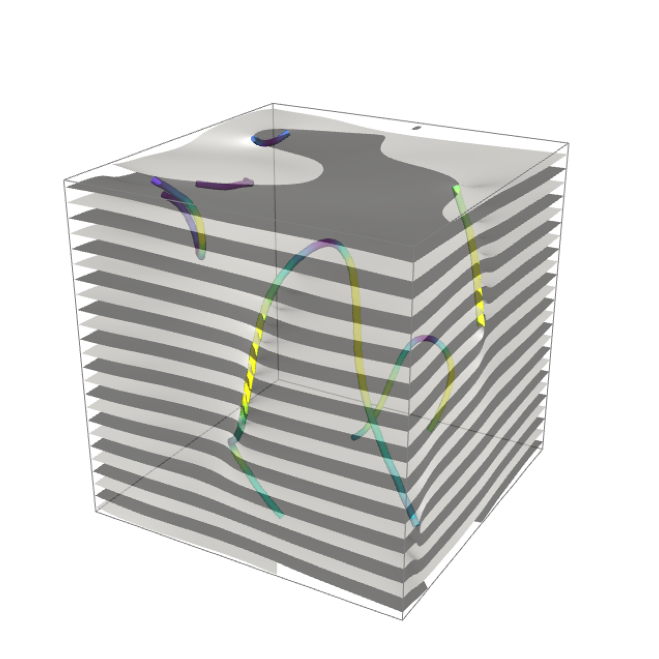

In [13]:
for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        parameters = parameters_list[i]

        print('parameters = [{:0.2f}, {:0>3d}, {:0.2f}]'.format(*parameters))
        fig = plt.figure(figsize=(4.2, 4.2),dpi=192)
        
        for i_t, t in tqdm(enumerate(t_list)):
            filename_defect = './Figures/test/test_t_deBroglie_{:0>3d}.png'.format(i_t)
            filename_lamellar = './Figures/test/test_t_deBroglie_lam_{:0>3d}.png'.format(i_t)
            
            img_defect = Image.open(filename_defect)
            img_lamellar = Image.open(filename_lamellar)
            blended = Image.blend(img_lamellar, img_defect, 0.33)

            img = np.asarray(blended)

            ax = plt.subplot(1,1,1)
            ax.imshow(img)
            ax.axis('off')
            plt.savefig(fname = './Figures/test/test_t_deBroglie_overlap_{:0>3d}.png'.format(i_t), bbox_inches='tight', pad_inches=0)  
            


In [14]:
anim_file = './Figures/defect_motion_deBroglie_overlap.gif'

with imageio.get_writer(anim_file, mode='I', loop=0, duration=1000*8/80) as writer:
  # filenames = glob.glob('./Figures/test/test_t_*.png')
  # filenames = sorted(filenames)
  for i_t, t in tqdm(enumerate(t_list)):
    filename = './Figures/test/test_t_deBroglie_overlap_{:0>3d}.png'.format(i_t)
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

81it [00:00, 118.66it/s]
